In [55]:
#%pip install ppscore
#%pip install hypertools

# to read CSV and for use with the library ppscore
import pandas as pd
from pandas.api.types import CategoricalDtype

# Plots
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = [5, 5]
mpl.rcParams.update({'font.size': 7})
#import hypertools as hyp

# EDA
import numpy as np
import ppscore as pps
from scipy import stats

# Plotly
import plotly.express as px
import plotly.graph_objects as go


In [56]:
# make a color map of fixed colors
color_iris_setosa = 'xkcd:baby purple'
color_iris_versicolor = 'xkcd:purplish blue'
color_iris_virginica = 'xkcd:periwinkle blue'
color_iris_setosa_hex = '#CA9BF7'
color_iris_versicolor_hex = '#601EF9'
color_iris_virginica_hex = '#8F99FB'
custom_cmap = colors.ListedColormap([color_iris_setosa, color_iris_versicolor, color_iris_virginica])
custom_cmap_bounds=[0,1,2]
custom_cmap_norm = colors.BoundaryNorm(custom_cmap_bounds, custom_cmap.N)

label_iris_setosa = 0
label_iris_versicolor = 1
label_iris_virginica = 2

In [57]:
# in this code block we define a function to read the dataset from a CSV file and perform some very basic preprocessing

def load_dataset(path: str, sep: str, target_column_name: str, target_name_column_name: str, columns_to_drop: list, column_name_mapping: dict, target_class_mapping: dict):

    target_column_is_index = False
    target_column_index = -1
    if(target_column_name.isnumeric()):
        target_column_is_index = True
        target_column_index = int(target_column_name)

    # read the CSV file
    # using separator character semicolon
    X_original_y_pd = pd.read_csv(path, sep=sep, skipinitialspace=True)

    # make column names pythonic
    # so that they can be used in code where applicable
    X_original_y_pd.columns = X_original_y_pd.columns.str.replace(" ", "_")

    for column_to_drop in columns_to_drop:
        X_original_y_pd.drop(column_to_drop, axis=1, inplace=True)

    X_original_y_pd.rename(column_name_mapping, axis=1, inplace=True)

    X_original_y_pd[target_name_column_name] = X_original_y_pd[target_column_name]
    X_original_y_pd[target_column_name] = X_original_y_pd[target_column_name].map(target_class_mapping)

    # on a side note we choose to sort the data frame by the target column
    #X_original_y_pd.sort_values(by='species', ascending=True, axis=0, inplace=True)

    X_y_np = X_original_y_pd.to_numpy()

    # number of instances often referred to as just n
    n_samples = X_y_np.shape[0]
    print(f"n_samples={n_samples}")

    # number of target variables
    n_targets = 1
    print(f"n_targets={n_targets}")

    # number of target classes
    #n_target_classes = 3
    #print(f"n_target_classes={n_target_classes}")

    # number of features
    n_features = X_y_np.shape[1] - n_targets
    print(f"n_features={n_features}")

    assert X_y_np.shape == (n_samples, n_features + n_targets)
    assert X_y_np.shape == (n_samples, n_features + n_targets)

    X_original_pd = X_original_y_pd.copy().drop(target_column_name, axis=1)
    X_original_pd.drop(target_name_column_name, axis=1)
    X_original_np = X_original_pd.to_numpy()
    assert X_original_np.shape == (n_samples,n_features)

    y_pd = X_original_y_pd[target_column_name].copy()
    y_np = y_pd.to_numpy()
    assert y_np.shape == (n_samples,)

    return (X_original_pd, y_pd, X_original_np, y_np, X_original_y_pd)


In [58]:
# in this code block we execute the above function to load the data

n_targets = 1
n_target_classes = 3

target_column_name = 'species'
target_name_column_name = 'species-name'

columns_to_drop = ['Id']

column_name_mapping = {'SepalLengthCm': 'sepal_length',
    'SepalWidthCm': 'sepal_width',
    'PetalLengthCm': 'petal_length',
    'PetalWidthCm': 'petal_width',
    'Species': 'species'}

target_class_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
assert len(target_class_mapping) == n_target_classes

X_original_pd, y_pd, X_original_np, y_np, X_original_y_pd = load_dataset("../data/iris.csv",
    ',', target_column_name, target_name_column_name,
    columns_to_drop, column_name_mapping, target_class_mapping)


n_samples=150
n_targets=1
n_features=5


In [59]:
# in this code block we define a function to perform an EDA

def explore_dataset(X_original_y_pd, X_y_np, n_target_classes, target_column_name, target_class_mapping):

    target_class_values = list(target_class_mapping.values())
    target_class_values = [float(i) for i in target_class_values]
    target_class_names = list(target_class_mapping.keys())

    print(f"target_class_values={target_class_values}")
    print(f"target_class_names={target_class_names}")
    print(f"target_class_mapping={target_class_mapping}")

    target_column_cat_name = f"{target_column_name}_cat"
    n_target_classes_range = range(n_target_classes)
    target_classes_int = [*n_target_classes_range]

    # number of instances
    print(f"n={X_y_np.shape[0]}")

    # location parameters
    print(f"mean={X_y_np.mean(axis=0)}")
    print(f"trimmed_mean={stats.trim_mean(X_y_np.astype('float32'), proportiontocut=0.10, axis=0)}")
    print(f"mode={stats.mode(X_y_np, keepdims=True)}")

    # statistical dispersion measures
    def range_np(a: np.ndarray) -> np.ndarray:
        result = a.max(axis=0) - a.min(axis=0)
        return result

    print(f"range={range_np(X_y_np)}")
    print(f"iqr={stats.iqr(X_y_np, axis=0)}")

    print(f"percentile_10={np.percentile(X_y_np, 10.0, axis=0)}")
    print(f"percentile_25={np.percentile(X_y_np, 25.0, axis=0)}")
    print(f"median={np.percentile(X_y_np, 50.0, axis=0)}")
    print(f"percentile_75={np.percentile(X_y_np, 75.0, axis=0)}")
    print(f"percentile_90={np.percentile(X_y_np, 90.0, axis=0)}")

    def mad_np(a: np.ndarray) -> np.ndarray:
        result = np.mean(np.absolute(a - np.mean(a, axis=0)), axis=0)
        return result

    print(f"mad={mad_np(X_y_np)}")

    print(f"std={X_y_np.std(axis=0)}")
    print(f"var={X_y_np.var(axis=0)}")

    # association measures
    print(f"\ncorrelation_matrix=\n{np.corrcoef(X_y_np, rowvar=False).round(decimals=2)}")

    # we have a look at a scatter matrix
    pd.plotting.scatter_matrix(X_original_y_pd,
                            c=X_original_y_pd[target_column_name],
                            figsize=(17, 17),
                            cmap = cm['cool'],
                            diagonal = 'kde')

    # for the computation of predictive power scores we use pandas categorical data type for class_cat
    class_categories_pd = CategoricalDtype(categories=target_classes_int, ordered=True)
    X_original_y_cat_pd = X_original_y_pd.copy()
    X_original_y_cat_pd[target_column_cat_name] = X_original_y_pd[target_column_name].astype(class_categories_pd)
    X_original_y_cat_pd.drop(target_column_name, axis=1, inplace=True)

    #predictive_power_score_matrix_all_pd = pps.matrix(df_pd_all, output='df')
    predictive_power_scores_pd = pps.predictors(X_original_y_cat_pd, y=target_column_cat_name, output='df')
    predictive_power_scores_pd.style.background_gradient(cmap='twilight', low=0.0, high=1.0)
    print(predictive_power_scores_pd)


In [60]:
X_original_y_pd.max()

sepal_length               7.9
sepal_width                4.4
petal_length               6.9
petal_width                2.5
species                      2
species-name    Iris-virginica
dtype: object

     sepal_length  sepal_width  petal_length  petal_width  species  \
0             5.1          3.5           1.4          0.2        0   
1             4.9          3.0           1.4          0.2        0   
2             4.7          3.2           1.3          0.2        0   
3             4.6          3.1           1.5          0.2        0   
4             5.0          3.6           1.4          0.2        0   
..            ...          ...           ...          ...      ...   
145           6.7          3.0           5.2          2.3        2   
146           6.3          2.5           5.0          1.9        2   
147           6.5          3.0           5.2          2.0        2   
148           6.2          3.4           5.4          2.3        2   
149           5.9          3.0           5.1          1.8        2   

       species-name  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  

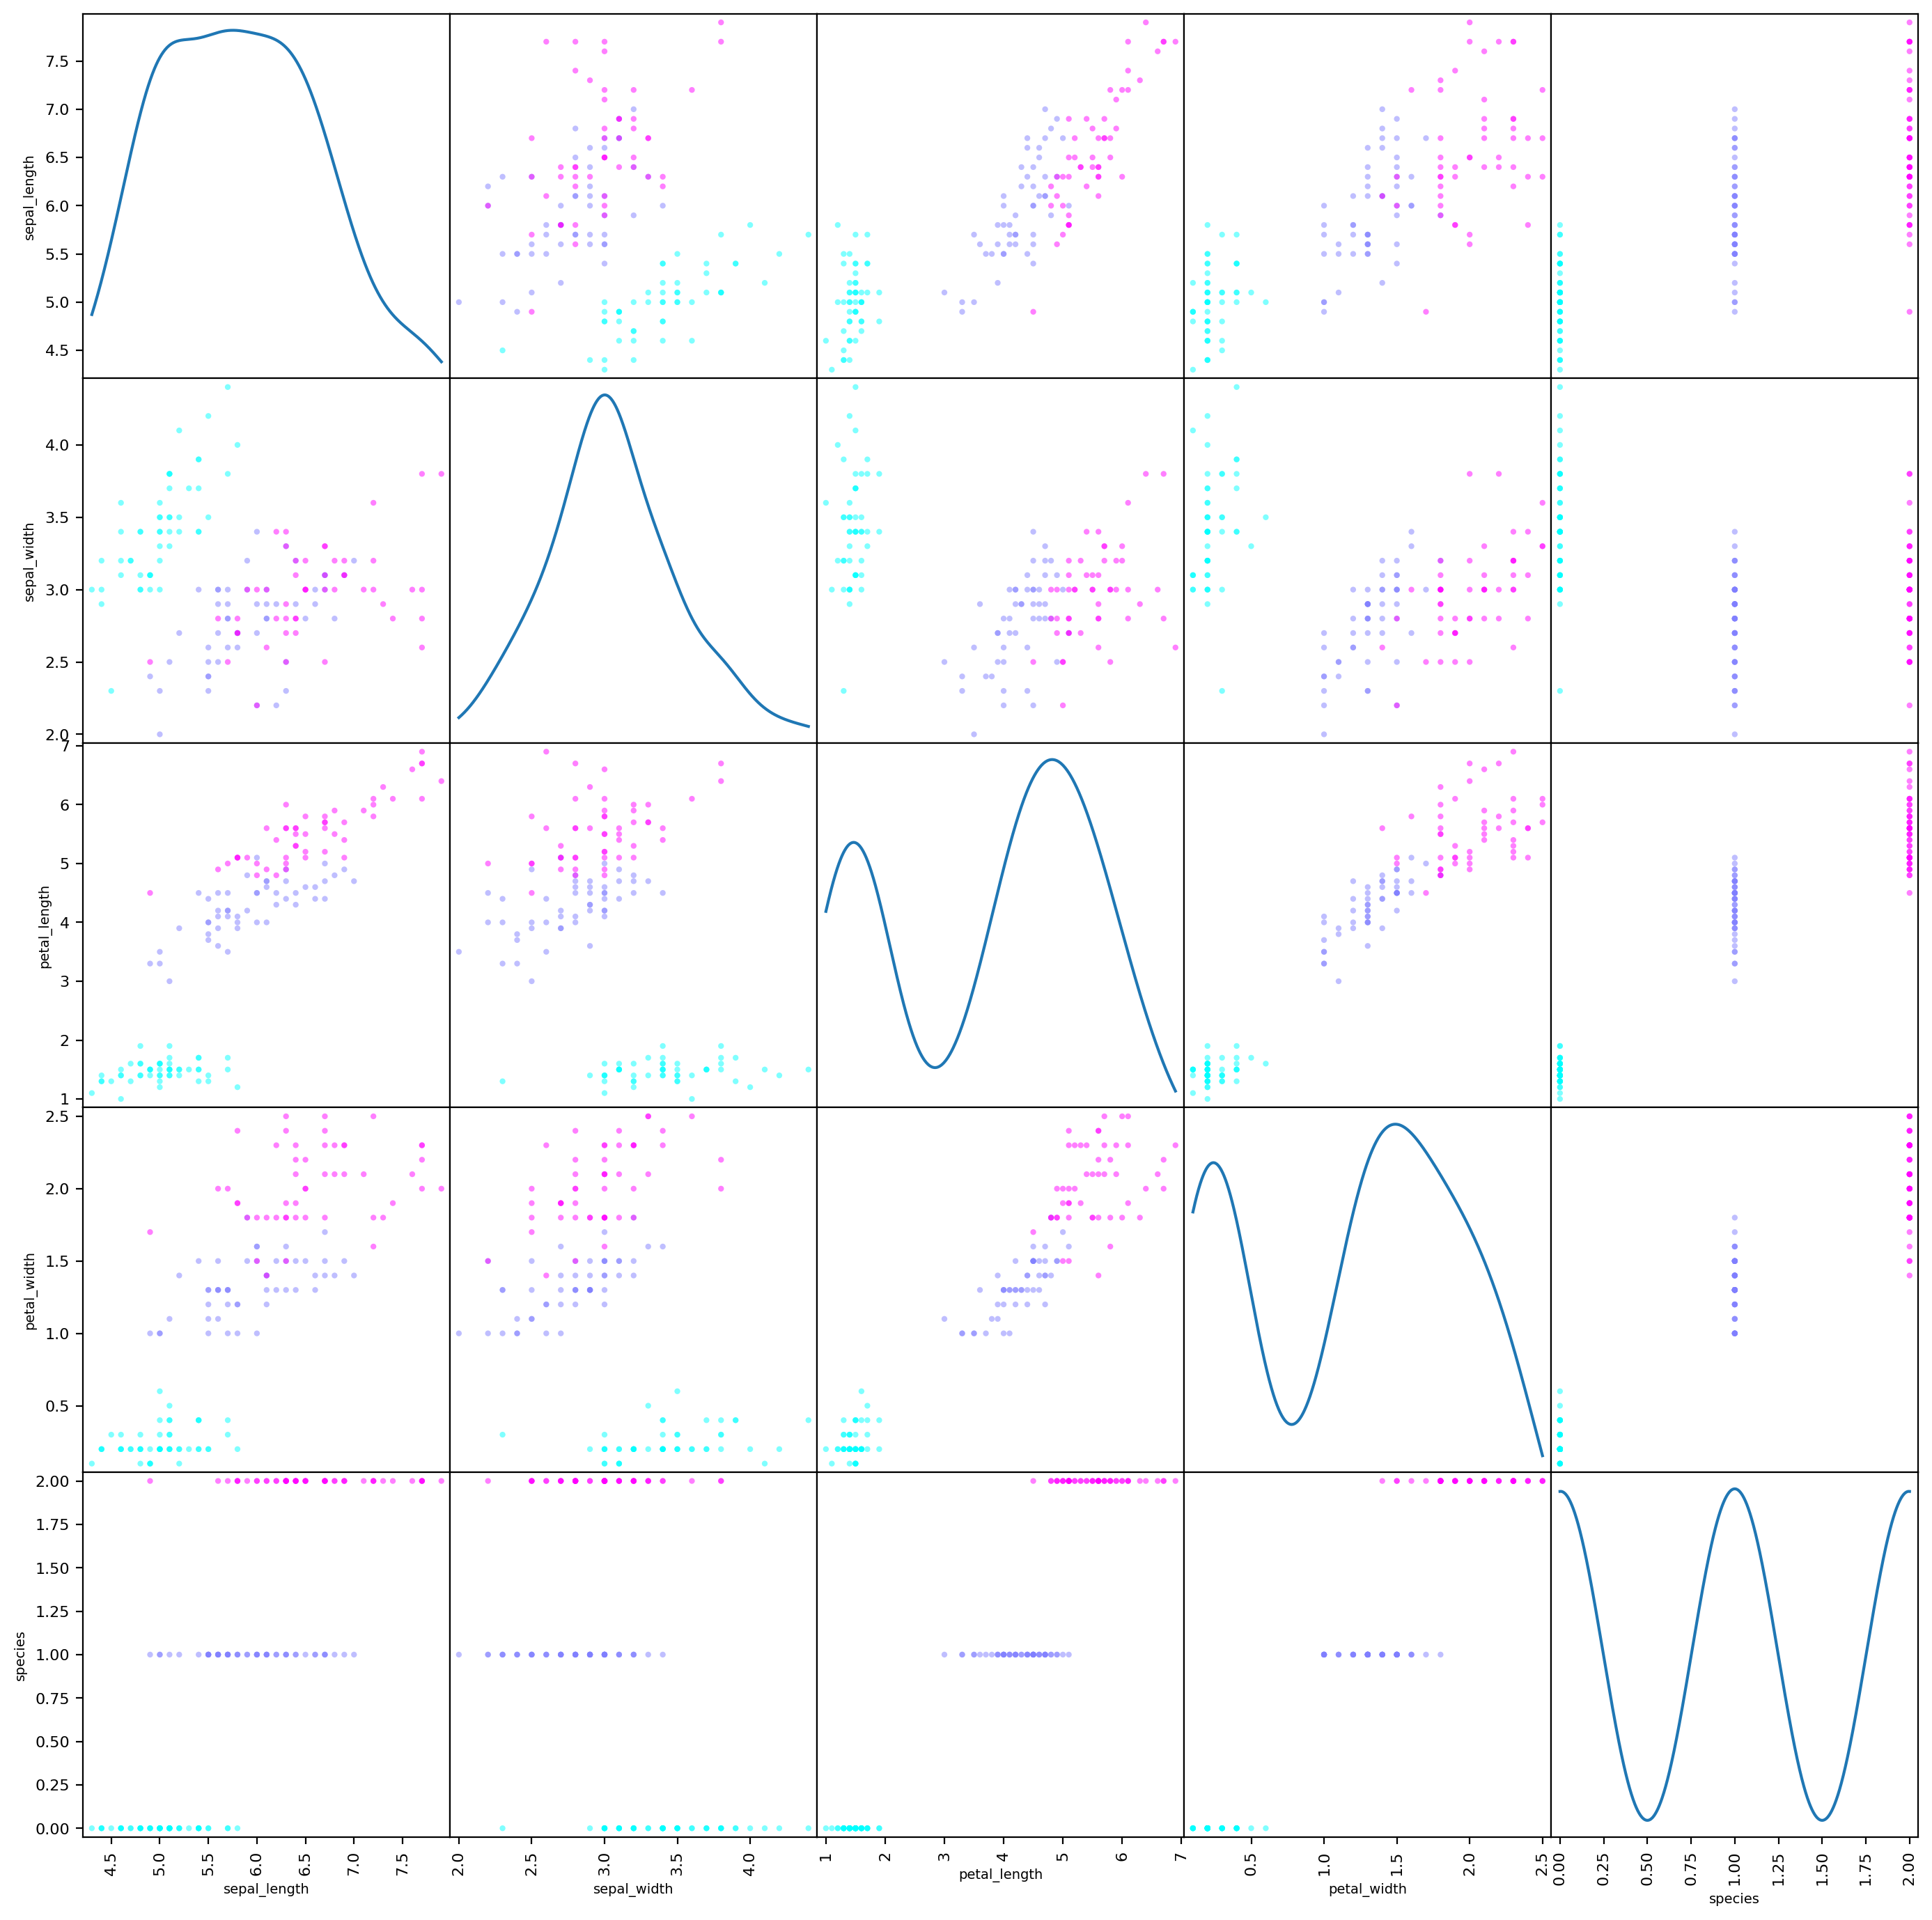

In [61]:
# in this code block we explore the data set

print(X_original_y_pd)

explore_dataset(X_original_y_pd, X_original_y_pd.copy().drop(target_name_column_name, axis=1).to_numpy(), n_target_classes, 'species', target_class_mapping)


In [62]:
X_sepal_length_cm_np = X_original_np[:,0]
print(f"X_sepal_length_cm_np.shape={X_sepal_length_cm_np.shape}")
print(f"X_sepal_length_cm_np.max={X_sepal_length_cm_np.max()}")
X_sepal_width_cm_np = X_original_np[:,1]
print(f"X_sepal_width_cm_np.shape={X_sepal_width_cm_np.shape}")
print(f"X_sepal_width_cm_np.max={X_sepal_width_cm_np.max()}")
X_petal_length_cm_np = X_original_np[:,2]
print(f"X_petal_length_cm_np.shape={X_petal_length_cm_np.shape}")
print(f"X_petal_length_cm_np.max={X_petal_length_cm_np.max()}")
X_petal_width_cm_np = X_original_np[:,3]
print(f"X_petal_width_cm_np.shape={X_petal_width_cm_np.shape}")
print(f"X_petal_width_cm_np.max={X_petal_width_cm_np.max()}")
print(f"y_np={y_np}")
print()
print(f"X_sepal_length_cm_np.shape={X_sepal_length_cm_np[y_np == label_iris_setosa].shape}")
print(f"X_sepal_length_cm_np.max={X_sepal_length_cm_np[y_np == label_iris_setosa].max()}")
print(f"X_sepal_width_cm_np.shape={X_sepal_width_cm_np[y_np == label_iris_setosa].shape}")
print(f"X_sepal_width_cm_np.max={X_sepal_width_cm_np[y_np == label_iris_setosa].max()}")
print(f"X_petal_length_cm_np.shape={X_petal_length_cm_np[y_np == label_iris_setosa].shape}")
print(f"X_petal_length_cm_np.max={X_petal_length_cm_np[y_np == label_iris_setosa].max()}")
print(f"X_petal_width_cm_np.shape={X_petal_width_cm_np[y_np == label_iris_setosa].shape}")
print(f"X_petal_width_cm_np.max={X_petal_width_cm_np[y_np == label_iris_setosa].max()}")
print()
print(f"X_sepal_length_cm_np.shape={X_sepal_length_cm_np[y_np == label_iris_versicolor].shape}")
print(f"X_sepal_length_cm_np.max={X_sepal_length_cm_np[y_np == label_iris_versicolor].max()}")
print(f"X_sepal_width_cm_np.shape={X_sepal_width_cm_np[y_np == label_iris_versicolor].shape}")
print(f"X_sepal_width_cm_np.max={X_sepal_width_cm_np[y_np == label_iris_versicolor].max()}")
print(f"X_petal_length_cm_np.shape={X_petal_length_cm_np[y_np == label_iris_versicolor].shape}")
print(f"X_petal_length_cm_np.max={X_petal_length_cm_np[y_np == label_iris_versicolor].max()}")
print(f"X_petal_width_cm_np.shape={X_petal_width_cm_np[y_np == label_iris_versicolor].shape}")
print(f"X_petal_width_cm_np.max={X_petal_width_cm_np[y_np == label_iris_versicolor].max()}")
print()
print(f"X_sepal_length_cm_np.shape={X_sepal_length_cm_np[y_np == label_iris_virginica].shape}")
print(f"X_sepal_length_cm_np.max={X_sepal_length_cm_np[y_np == label_iris_virginica].max()}")
print(f"X_sepal_width_cm_np.shape={X_sepal_width_cm_np[y_np == label_iris_virginica].shape}")
print(f"X_sepal_width_cm_np.max={X_sepal_width_cm_np[y_np == label_iris_virginica].max()}")
print(f"X_petal_length_cm_np.shape={X_petal_length_cm_np[y_np == label_iris_virginica].shape}")
print(f"X_petal_length_cm_np.max={X_petal_length_cm_np[y_np == label_iris_virginica].max()}")
print(f"X_petal_width_cm_np.shape={X_petal_width_cm_np[y_np == label_iris_virginica].shape}")
print(f"X_petal_width_cm_np.max={X_petal_width_cm_np[y_np == label_iris_virginica].max()}")

X_sepal_length_cm_np.shape=(150,)
X_sepal_length_cm_np.max=7.9
X_sepal_width_cm_np.shape=(150,)
X_sepal_width_cm_np.max=4.4
X_petal_length_cm_np.shape=(150,)
X_petal_length_cm_np.max=6.9
X_petal_width_cm_np.shape=(150,)
X_petal_width_cm_np.max=2.5
y_np=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]

X_sepal_length_cm_np.shape=(50,)
X_sepal_length_cm_np.max=5.8
X_sepal_width_cm_np.shape=(50,)
X_sepal_width_cm_np.max=4.4
X_petal_length_cm_np.shape=(50,)
X_petal_length_cm_np.max=1.9
X_petal_width_cm_np.shape=(50,)
X_petal_width_cm_np.max=0.6

X_sepal_length_cm_np.shape=(50,)
X_sepal_length_cm_np.max=7.0
X_sepal_width_cm_np.shape=(50,)
X_sepal_width_cm_np.max=3.4
X_petal_length_cm_np.shape=(50,)
X_petal_length_cm_np.max=5.1
X_petal_wid

In [63]:
fig = px.sunburst(
    X_original_y_pd,
    path=['species-name', 'petal_length', 'petal_width'],
    title="Iris Blütenblatt | Abmessungen in cm | Art > Länge > Breite"
)
fig.show()

In [64]:
fig = px.sunburst(
    X_original_y_pd,
    path=['species-name', 'petal_width', 'petal_length'],
    title="Iris Blütenblatt | Abmessungen in cm | Art > Breite > Länge"
)
fig.show()

In [65]:
fig = px.sunburst(
    X_original_y_pd,
    path=['species-name', 'sepal_length', 'sepal_width'],
    title="Iris Kelchblatt | Abmessungen in cm | Art > Länge > Breite"
)
fig.show()

In [66]:
fig = px.sunburst(
    X_original_y_pd,
    path=['species-name', 'sepal_width', 'sepal_length'],
    title="Iris Kelchblatt | Abmessungen in cm | Art > Breite > Länge"
)
fig.show()


In [67]:
fig = px.sunburst(
    X_original_y_pd,
    path=['species-name', 'petal_length', 'petal_width', 'sepal_width', 'sepal_length'],
    title="Iris | Abmessungen in cm | Art > Blütenblatt Länge > Breite > Kelchblatt Länge > Breite"
)
fig.show()